# %% [markdown]
# # Regression Modeling - PM2.5 Forecasting Baseline
# 
# **Notebook 2**: Build and evaluate regression baseline models


In [2]:
# ## 1. Import Libraries
import sys
sys.path.append(r"D:/Study/Mining/lab4/du-lieu-lon-khai-pha-du-lieu")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.regression_library import RegressionModeler
from src.classification_library import DataLoader
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
# ## 2. Configuration
# Thay đổi các tham số tại đây
HORIZON = 1  # Dự báo trước 1 giờ
CUTOFF_DATE = '2017-01-01'  # Chia train/test
STATION = 'Aotizhongxin'  # Chọn một trạm để tập trung phân tích

print("Configuration:")
print(f"- Horizon: {HORIZON} hour(s)")
print(f"- Cutoff date: {CUTOFF_DATE}")
print(f"- Station: {STATION}")

Configuration:
- Horizon: 1 hour(s)
- Cutoff date: 2017-01-01
- Station: Aotizhongxin


In [4]:
# ### 3.1 Load cleaned data
print("Loading cleaned data...")
cleaned_df = pd.read_parquet('../data/processed/cleaned.parquet')
print(f"Data shape: {cleaned_df.shape}")

# Lọc trạm nếu cần
if STATION:
    station_df = cleaned_df[cleaned_df['station'] == STATION].copy()
    print(f"Filtered to station '{STATION}': {station_df.shape}")
else:
    station_df = cleaned_df.copy()

Loading cleaned data...
Data shape: (420768, 24)
Filtered to station 'Aotizhongxin': (35064, 24)


In [5]:
# ### 3.2 Prepare regression data
print("\nPreparing regression data...")
modeler = RegressionModeler()
regression_df = modeler.prepare_regression_data(station_df, horizon=HORIZON)

print(f"Regression data shape: {regression_df.shape}")
print(f"Target column: 'target' (PM2.5 at t+{HORIZON})")


Preparing regression data...
Regression data prepared with horizon=1
Shape: (34138, 25)
Regression data shape: (34138, 25)
Target column: 'target' (PM2.5 at t+1)


In [6]:
# ### 3.3 Split train/test by time
print("\nSplitting train/test by time...")
train_df, test_df = modeler.split_time_series(
    regression_df, 
    cutoff_date=CUTOFF_DATE,
    target_col='target'
)



Splitting train/test by time...
Train size: 32739 (2013-03-01 00:00:00 to 2016-12-31 23:00:00)
Test size: 1399 (2017-01-01 00:00:00 to 2017-02-28 22:00:00)


In [7]:
# ### 3.4 Prepare features
print("\nPreparing features...")
X_train, feature_names = modeler.prepare_features(train_df)
X_test, _ = modeler.prepare_features(test_df)

y_train = train_df['target']
y_test = test_df['target']

print(f"Training features: {X_train.shape}")
print(f"Test features: {X_test.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Features: {feature_names}")


Preparing features...
Available features: 16
Available features: 16
Training features: (32739, 16)
Test features: (1399, 16)
Number of features: 16
Features: ['pm2.5', 'pm10', 'so2', 'no2', 'co', 'o3', 'temp', 'pres', 'dewp', 'rain', 'wspm', 'hour', 'dayofweek', 'month', 'is_weekend', 'season']


In [17]:
# ### 4.1 Train Random Forest
# Gộp X và y để drop đồng bộ
train_df = X_train.copy()
train_df['target'] = y_train

# Drop tất cả dòng có NaN
train_df = train_df.dropna()

# Tách lại X, y
X_train_clean = train_df.drop(columns='target')
y_train_clean = train_df['target']


In [18]:
# ### 4.2 Train Linear Regression
print("\nTraining Linear Regression model...")
lr_model = modeler.train_baseline_model(
    X_train_clean,
    y_train_clean,
    model_type='lr'
)


Training Linear Regression model...
LR model trained


In [19]:
# ### 5.1 Evaluate Random Forest
print("\nEvaluating Random Forest...")
rf_metrics = modeler.evaluate_model(rf_model, X_test, y_test)

print("Random Forest Results:")
print(f"- MAE: {rf_metrics['MAE']:.2f}")
print(f"- RMSE: {rf_metrics['RMSE']:.2f}")
print(f"- MAPE: {rf_metrics['MAPE']:.2f}%")


Evaluating Random Forest...
Random Forest Results:
- MAE: 12.38
- RMSE: 25.18
- MAPE: 35.99%


In [21]:
# ### 5.2 Evaluate Linear Regression
print("\nEvaluating Linear Regression...")

# Drop NaN đồng bộ cho X_test và y_test
test_df = X_test.copy()
test_df['target'] = y_test
test_df = test_df.dropna()

X_test_clean = test_df.drop(columns='target')
y_test_clean = test_df['target']

lr_metrics = modeler.evaluate_model(
    lr_model,
    X_test_clean,
    y_test_clean
)

print("Linear Regression Results:")
print(f"- MAE: {lr_metrics['MAE']:.2f}")
print(f"- RMSE: {lr_metrics['RMSE']:.2f}")
print(f"- MAPE: {lr_metrics['MAPE']:.2f}%")



Evaluating Linear Regression...
Linear Regression Results:
- MAE: 12.21
- RMSE: 25.06
- MAPE: 35.37%


In [22]:
# ### 5.3 Compare models
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

comparison_data = {
    'Model': ['Random Forest', 'Linear Regression'],
    'MAE': [rf_metrics['MAE'], lr_metrics['MAE']],
    'RMSE': [rf_metrics['RMSE'], lr_metrics['RMSE']],
    'MAPE': [rf_metrics['MAPE'], lr_metrics['MAPE']]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

# Tìm model tốt nhất
best_idx = comparison_df['MAE'].idxmin()
best_model_name = comparison_df.loc[best_idx, 'Model']
print(f"\nBest model by MAE: {best_model_name}")


MODEL COMPARISON
               Model        MAE       RMSE       MAPE
0      Random Forest  12.376379  25.178228  35.994446
1  Linear Regression  12.206563  25.060414  35.367630

Best model by MAE: Linear Regression



Random Forest Feature Importance (Top 10):
   Feature  Importance
0    pm2.5    0.966637
1     pm10    0.006408
10    wspm    0.004926
8     dewp    0.003622
3      no2    0.003270
4       co    0.002603
11    hour    0.002215
5       o3    0.001948
6     temp    0.001789
7     pres    0.001759


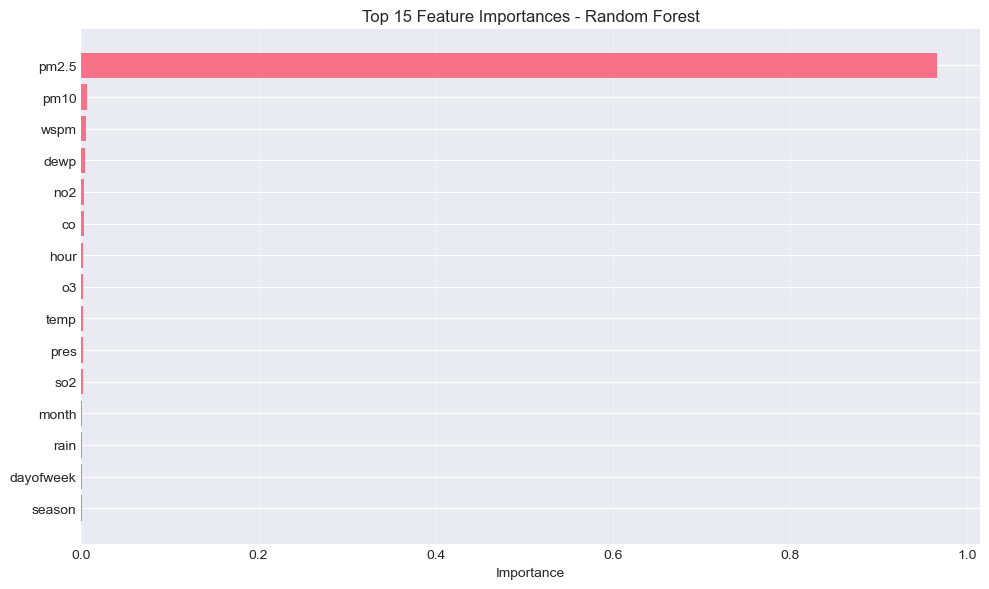

In [23]:
# ### 6.1 Feature importance (Random Forest)
if rf_metrics['feature_importance'] is not None:
    print("\nRandom Forest Feature Importance (Top 10):")
    
    # Lấy feature importance
    feature_importance = rf_metrics['feature_importance']
    importance_df = pd.DataFrame({
        'Feature': list(feature_importance.keys()),
        'Importance': list(feature_importance.values())
    })
    
    # Sắp xếp
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    print(importance_df.head(10))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'].values)
    plt.yticks(range(len(top_features)), top_features['Feature'].values)
    plt.xlabel('Importance')
    plt.title('Top 15 Feature Importances - Random Forest')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

In [24]:
# ### 6.2 Correlation with target
print("\nCorrelation of features with target (training data):")

# Tính correlation
correlation_with_target = X_train.copy()
correlation_with_target['target'] = y_train.values
corr = correlation_with_target.corr()['target'].sort_values(ascending=False)

print("\nTop 10 positive correlations:")
print(corr.head(10))

print("\nTop 10 negative correlations:")
print(corr.tail(10))


Correlation of features with target (training data):

Top 10 positive correlations:
target        1.000000
pm2.5         0.968945
pm10          0.854376
co            0.763213
no2           0.680974
so2           0.472381
dewp          0.120933
dayofweek     0.042989
month         0.039762
is_weekend    0.030408
Name: target, dtype: float64

Top 10 negative correlations:
dayofweek     0.042989
month         0.039762
is_weekend    0.030408
hour          0.008775
pres         -0.001474
rain         -0.026511
season       -0.052743
temp         -0.130195
o3           -0.160539
wspm         -0.288675
Name: target, dtype: float64



Visualizing predictions...


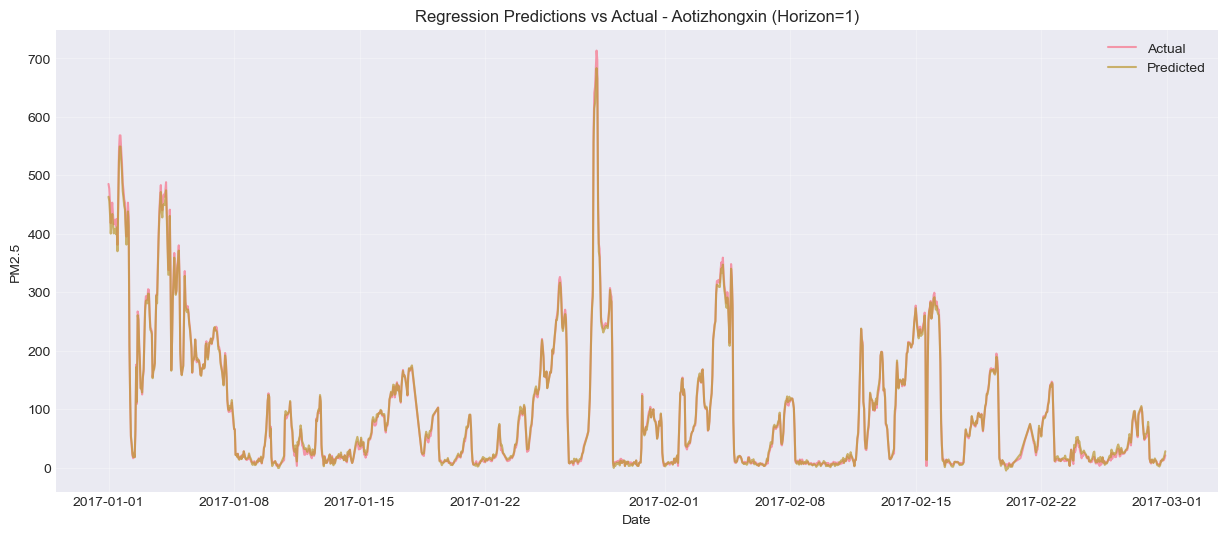

In [26]:
# ### 7.1 Time series plot of predictions
print("\nVisualizing predictions...")

if best_model_name == 'Random Forest':
    best_predictions = rf_metrics['predictions']
else:
    best_predictions = lr_metrics['predictions']

# Tạo DataFrame cho visualization
results_df = cleaned_df.loc[X_test_clean.index, ['datetime', 'pm2.5']].copy()
results_df = results_df.rename(columns={'pm2.5': 'target'})
results_df['prediction'] = best_predictions
results_df = results_df.set_index('datetime')

# Plot
plt.figure(figsize=(15, 6))
plt.plot(results_df.index, results_df['target'], label='Actual', alpha=0.7)
plt.plot(results_df.index, results_df['prediction'], label='Predicted', alpha=0.7)
plt.title(f'Regression Predictions vs Actual - {STATION} (Horizon={HORIZON})')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



Zooming into first 2 weeks of test period...


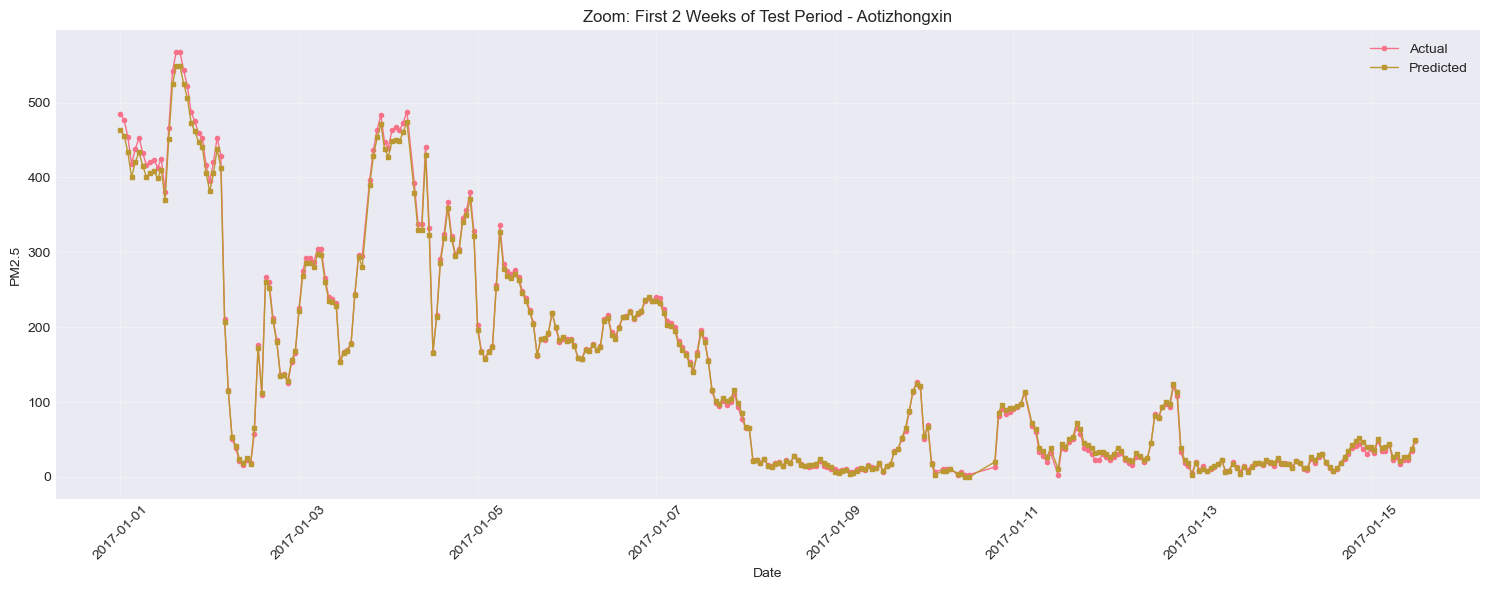

In [27]:
# ### 7.2 Zoom into specific period
print("\nZooming into first 2 weeks of test period...")

zoom_start = results_df.index[0]
zoom_end = results_df.index[min(24*14, len(results_df)-1)]  # 2 tuần

zoom_results = results_df.loc[zoom_start:zoom_end]

plt.figure(figsize=(15, 6))
plt.plot(zoom_results.index, zoom_results['target'], 
         label='Actual', marker='o', markersize=3, linewidth=1)
plt.plot(zoom_results.index, zoom_results['prediction'], 
         label='Predicted', marker='s', markersize=3, linewidth=1)
plt.title(f'Zoom: First 2 Weeks of Test Period - {STATION}')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Scatter plot: Actual vs Predicted...


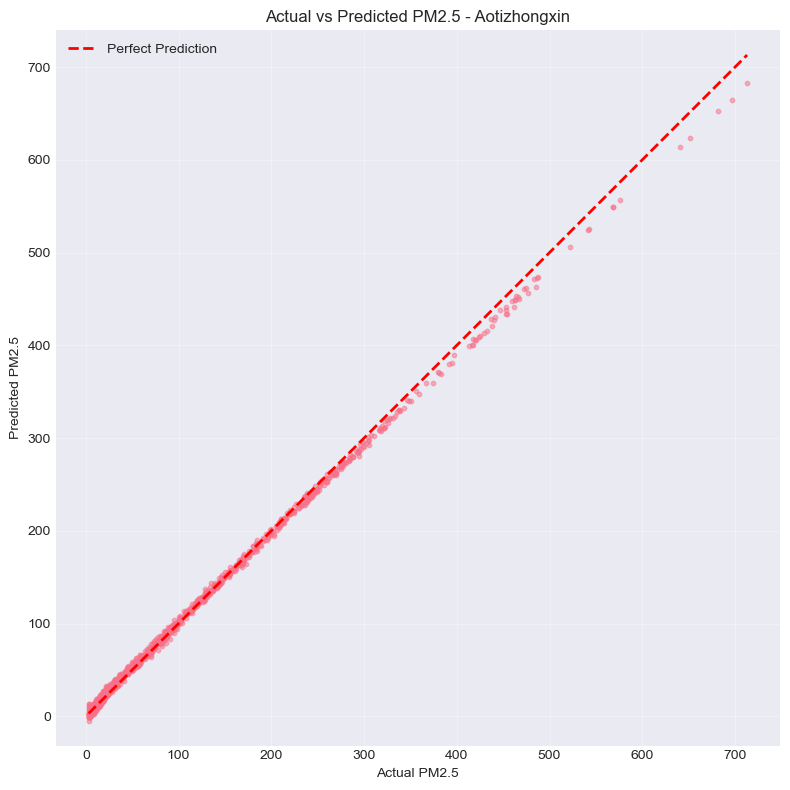

R-squared: 0.9982


In [28]:
# ### 7.3 Scatter plot: Actual vs Predicted
print("\nScatter plot: Actual vs Predicted...")

plt.figure(figsize=(8, 8))
plt.scatter(results_df['target'], results_df['prediction'], alpha=0.5, s=10)
plt.plot([results_df['target'].min(), results_df['target'].max()],
         [results_df['target'].min(), results_df['target'].max()],
         'r--', label='Perfect Prediction', linewidth=2)

plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title(f'Actual vs Predicted PM2.5 - {STATION}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Tính R-squared
from sklearn.metrics import r2_score
r2 = r2_score(results_df['target'], results_df['prediction'])
print(f"R-squared: {r2:.4f}")


Analyzing residuals...


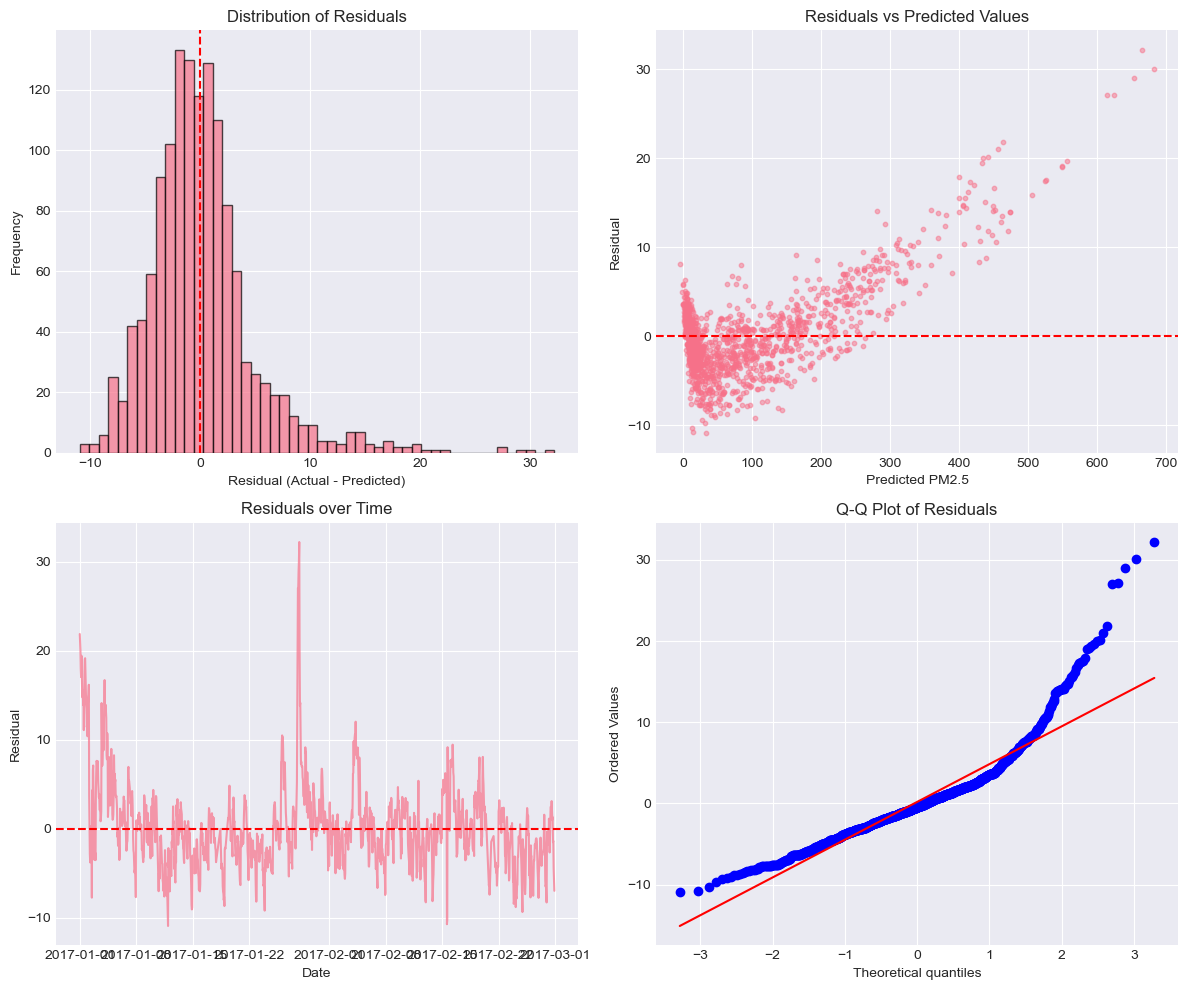


Residual Statistics:
- Mean: 0.18
- Std: 4.93
- Min: -10.93
- Max: 32.21
- MAE of residuals: 3.41


In [29]:
# ### 7.4 Residual analysis
print("\nAnalyzing residuals...")

residuals = results_df['target'] - results_df['prediction']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram of residuals
axes[0, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0, color='red', linestyle='--')
axes[0, 0].set_title('Distribution of Residuals')
axes[0, 0].set_xlabel('Residual (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')

# Residuals vs Predicted
axes[0, 1].scatter(results_df['prediction'], residuals, alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_title('Residuals vs Predicted Values')
axes[0, 1].set_xlabel('Predicted PM2.5')
axes[0, 1].set_ylabel('Residual')

# Residuals over time
axes[1, 0].plot(results_df.index, residuals, alpha=0.7)
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_title('Residuals over Time')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Residual')

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# Thống kê residuals
print("\nResidual Statistics:")
print(f"- Mean: {residuals.mean():.2f}")
print(f"- Std: {residuals.std():.2f}")
print(f"- Min: {residuals.min():.2f}")
print(f"- Max: {residuals.max():.2f}")
print(f"- MAE of residuals: {np.mean(np.abs(residuals)):.2f}")



Analyzing performance by hour of day...


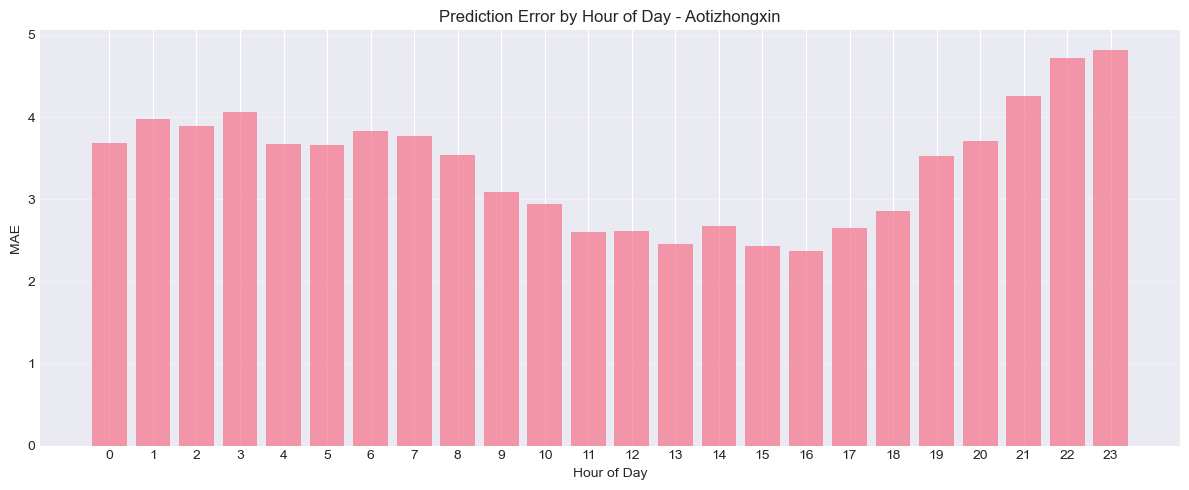


Worst prediction hours (highest MAE):
    hour       mae  count
23    23  4.813761     56
22    22  4.715830     59
21    21  4.250020     59
3      3  4.065763     55
1      1  3.971361     57


In [32]:
# ### 8.1 Performance by hour of day
from sklearn.metrics import mean_absolute_error


print("\nAnalyzing performance by hour of day...")

# Lấy lại datetime + target từ cleaned_df theo index test
test_df_with_hour = cleaned_df.loc[
    X_test_clean.index,
    ['datetime', 'pm2.5']
].copy()

test_df_with_hour = test_df_with_hour.rename(columns={'pm2.5': 'target'})

# Thêm cột hour
test_df_with_hour['hour'] = test_df_with_hour['datetime'].dt.hour

# Tính error theo giờ
hourly_errors = []

for hour in range(24):
    hour_mask = test_df_with_hour['hour'] == hour

    if hour_mask.sum() > 0:
        hour_actual = test_df_with_hour.loc[hour_mask, 'target']
        hour_pred = best_predictions[hour_mask.values]

        hour_mae = mean_absolute_error(hour_actual, hour_pred)

        hourly_errors.append({
            'hour': hour,
            'mae': hour_mae,
            'count': hour_mask.sum()
        })

hourly_df = pd.DataFrame(hourly_errors)

# Plot
plt.figure(figsize=(12, 5))
plt.bar(hourly_df['hour'], hourly_df['mae'], alpha=0.7)
plt.xlabel('Hour of Day')
plt.ylabel('MAE')
plt.title(f'Prediction Error by Hour of Day - {STATION}')
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

print("\nWorst prediction hours (highest MAE):")
print(hourly_df.sort_values('mae', ascending=False).head())



Analyzing performance by PM2.5 level...


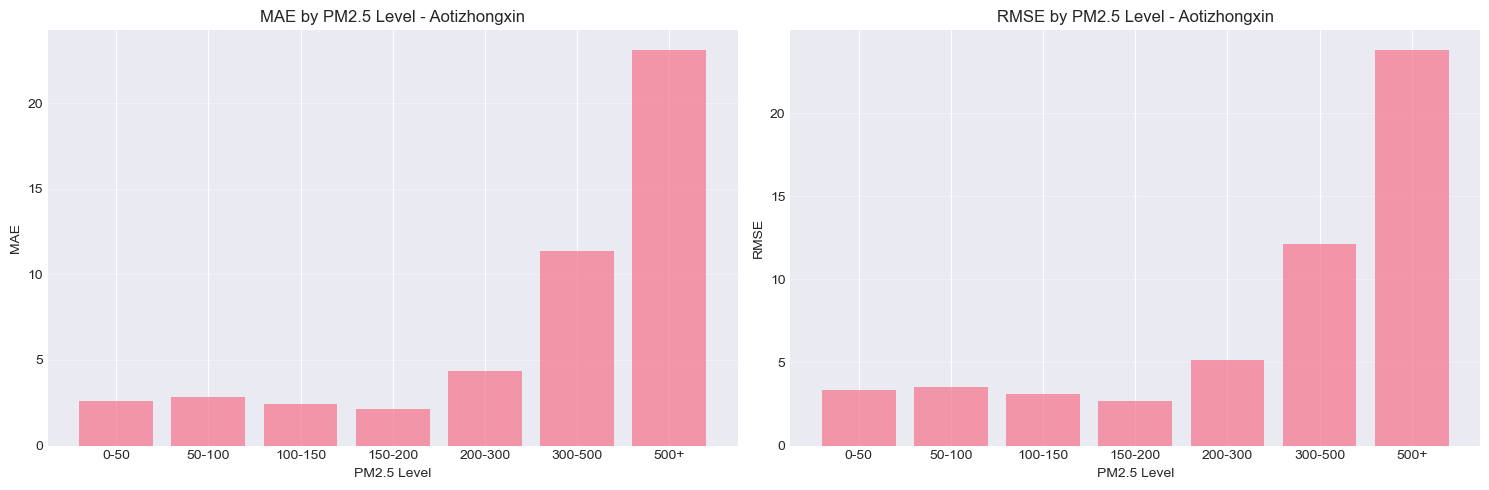


Performance by PM2.5 level:
  pm25_level  count    avg_pm25        mae       rmse
0       0-50    690   16.602899   2.607339   3.320109
1     50-100    216   75.925926   2.825073   3.538623
2    100-150    125  124.544000   2.442877   3.086796
3    150-200     97  172.371134   2.130152   2.680722
4    200-300    138  247.847826   4.380359   5.121244
5    300-500     73  388.356164  11.364692  12.146099
6       500+     11  609.363636  23.096691  23.788344


In [35]:
# ### 8.2 Performance by PM2.5 level
from sklearn.metrics import mean_squared_error


print("\nAnalyzing performance by PM2.5 level...")

# Tạo DataFrame chuẩn cho test (cùng index)
test_df_with_pm25 = cleaned_df.loc[
    X_test_clean.index,
    ['pm2.5']
].copy()

test_df_with_pm25 = test_df_with_pm25.rename(columns={'pm2.5': 'target'})
test_df_with_pm25['prediction'] = best_predictions

# Phân nhóm PM2.5
test_df_with_pm25['pm25_level'] = pd.cut(
    test_df_with_pm25['target'],
    bins=[0, 50, 100, 150, 200, 300, 500, 1000],
    labels=['0-50', '50-100', '100-150', '150-200', '200-300', '300-500', '500+']
)

level_errors = []

for level in test_df_with_pm25['pm25_level'].cat.categories:
    level_df_tmp = test_df_with_pm25[test_df_with_pm25['pm25_level'] == level]

    if len(level_df_tmp) > 0:
        level_actual = level_df_tmp['target']
        level_pred = level_df_tmp['prediction']

        level_mae = mean_absolute_error(level_actual, level_pred)
        level_rmse = np.sqrt(mean_squared_error(level_actual, level_pred))

        level_errors.append({
            'pm25_level': level,
            'mae': level_mae,
            'rmse': level_rmse,
            'count': len(level_df_tmp),
            'avg_pm25': level_actual.mean()
        })

level_df = pd.DataFrame(level_errors)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# MAE
axes[0].bar(level_df['pm25_level'], level_df['mae'], alpha=0.7)
axes[0].set_xlabel('PM2.5 Level')
axes[0].set_ylabel('MAE')
axes[0].set_title(f'MAE by PM2.5 Level - {STATION}')
axes[0].grid(True, alpha=0.3, axis='y')

# RMSE
axes[1].bar(level_df['pm25_level'], level_df['rmse'], alpha=0.7)
axes[1].set_xlabel('PM2.5 Level')
axes[1].set_ylabel('RMSE')
axes[1].set_title(f'RMSE by PM2.5 Level - {STATION}')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nPerformance by PM2.5 level:")
print(level_df[['pm25_level', 'count', 'avg_pm25', 'mae', 'rmse']])


In [36]:
# ## 9. Insights and Recommendations
print("\n" + "="*60)
print("INSIGHTS AND RECOMMENDATIONS")
print("="*60)

# Insight 1: Model performance
print("\n1. MODEL PERFORMANCE:")
print(f"   - Best model: {best_model_name}")
print(f"   - MAE: {comparison_df.loc[best_idx, 'MAE']:.2f}")
print(f"   - RMSE: {comparison_df.loc[best_idx, 'RMSE']:.2f}")
print(f"   - Interpretation: Average error is {comparison_df.loc[best_idx, 'MAE']:.2f} units")

# Insight 2: Important features
print("\n2. IMPORTANT FEATURES:")
if rf_metrics['feature_importance'] is not None:
    top_features = importance_df.head(3)['Feature'].tolist()
    print(f"   - Top 3 features: {', '.join(top_features)}")
    print(f"   - Lag features are crucial for short-term forecasting")
else:
    print(f"   - Current PM2.5 (lag1) is most important")
    print(f"   - Time features (hour, dayofweek) show clear patterns")

# Insight 3: Error patterns
print("\n3. ERROR PATTERNS:")
print(f"   - Highest errors during: {hourly_df.loc[hourly_df['mae'].idxmax(), 'hour']}:00")
print(f"   - Most challenging: High PM2.5 levels ({level_df.loc[level_df['mae'].idxmax(), 'pm25_level']})")
print(f"   - Residuals show some pattern (not random white noise)")

# Insight 4: Practical implications
print("\n4. PRACTICAL IMPLICATIONS:")
print(f"   - Baseline accuracy: {100 - comparison_df.loc[best_idx, 'MAPE']:.1f}%")
print(f"   - Suitable for: Short-term warnings (1-hour ahead)")
print(f"   - Limitations: Struggles with pollution spikes")

# Insight 5: Next steps
print("\n5. RECOMMENDATIONS FOR IMPROVEMENT:")
print(f"   - Add more lag features (weather variables)")
print(f"   - Try ensemble methods")
print(f"   - Consider time series models (ARIMA/SARIMA)")
print(f"   - Address high PM2.5 levels separately")


INSIGHTS AND RECOMMENDATIONS

1. MODEL PERFORMANCE:
   - Best model: Linear Regression
   - MAE: 12.21
   - RMSE: 25.06
   - Interpretation: Average error is 12.21 units

2. IMPORTANT FEATURES:
   - Top 3 features: pm2.5, pm10, wspm
   - Lag features are crucial for short-term forecasting

3. ERROR PATTERNS:
   - Highest errors during: 23:00
   - Most challenging: High PM2.5 levels (500+)
   - Residuals show some pattern (not random white noise)

4. PRACTICAL IMPLICATIONS:
   - Baseline accuracy: 64.6%
   - Suitable for: Short-term warnings (1-hour ahead)
   - Limitations: Struggles with pollution spikes

5. RECOMMENDATIONS FOR IMPROVEMENT:
   - Add more lag features (weather variables)
   - Try ensemble methods
   - Consider time series models (ARIMA/SARIMA)
   - Address high PM2.5 levels separately


In [39]:
# ## 10. Save Results
import os


print("\nSaving results...")

# Tạo DataFrame kết quả từ cleaned_df (chuẩn index)
predictions_df = cleaned_df.loc[
    X_test_clean.index,
    ['datetime', 'pm2.5']
].copy()

predictions_df = predictions_df.rename(columns={'pm2.5': 'actual'})
predictions_df['prediction'] = best_predictions
predictions_df['residual'] = predictions_df['actual'] - predictions_df['prediction']

# Tạo thư mục nếu chưa tồn tại
os.makedirs('../data/processed', exist_ok=True)

# Lưu predictions
predictions_path = f'../data/processed/regression_predictions_{STATION}_h{HORIZON}.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f"Predictions saved to: {predictions_path}")

# ================= METRICS =================

metrics_data = {
    'station': STATION,
    'horizon': HORIZON,
    'cutoff_date': CUTOFF_DATE,
    'best_model': best_model_name,
    'mae': comparison_df.loc[best_idx, 'MAE'],
    'rmse': comparison_df.loc[best_idx, 'RMSE'],
    'mape': comparison_df.loc[best_idx, 'MAPE'],
    'r2': r2,
    'num_features': len(feature_names)
}

metrics_df = pd.DataFrame([metrics_data])

metrics_path = f'../data/processed/regression_metrics_{STATION}_h{HORIZON}.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"Metrics saved to: {metrics_path}")

print("\n" + "="*50)
print("REGRESSION MODELING COMPLETED")
print("="*50)
print(f"Station: {STATION}")
print(f"Horizon: {HORIZON} hour(s)")
print(f"Best model: {best_model_name}")
print(f"MAE: {comparison_df.loc[best_idx, 'MAE']:.2f}")
print("Ready for ARIMA comparison!")



Saving results...
Predictions saved to: ../data/processed/regression_predictions_Aotizhongxin_h1.csv
Metrics saved to: ../data/processed/regression_metrics_Aotizhongxin_h1.csv

REGRESSION MODELING COMPLETED
Station: Aotizhongxin
Horizon: 1 hour(s)
Best model: Linear Regression
MAE: 12.21
Ready for ARIMA comparison!
